# CNN training example

This notebook illustrates how to use EDIT pipeline to train a simple CNN model on the ERA5 lowres dataset.

Make sure to set the `ERA5LOWRES` environment variable to make the ERA5 low-resolution archive foundable on your system.
Modify the following cell as follows:

- for NCI

```
%env ERA5LOWRES=/g/data/wb00/NCI-Weatherbench/5.625deg
```

- for NIWA

```
%env ERA5LOWRES=/nesi/nobackup/niwa00004/riom/weatherbench/5.625deg
```

In [1]:
%env ERA5LOWRES=/Users/joelmiller/Projects/data/weatherbench/5.625deg

env: ERA5LOWRES=/Users/joelmiller/Projects/data/weatherbench/5.625deg


In [2]:
import sys
from pathlib import Path

import numpy as np
import xarray as xr
import scores
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from lightning import Trainer, LightningModule
from lightning.pytorch.callbacks import RichProgressBar
from rich.progress import track

import edit.data
import edit.tutorial
import edit.pipeline
import edit.training

/Users/joelmiller/Projects/Python/EDIT/packages/data/src/edit/data/__init__.py:142: FutureWarning: `edit` is under heavy development and may not continue to be supported.
  __python_warnings.warn(


In [3]:
# train/validation/test split dates
train_start = "2015-01-01T00"
train_end = "2015-01-12T00"
val_start = "2016-01-01T00"
val_end = "2016-01-12T00"
test_start = "2017-01-01T00"
test_end = "2017-01-12T00"

# number of samples to estimate mean & standard deviation of fields
n_samples = 200
# folder to save estimated mean & standard deviation of fields
stats_folder = "cnn_training/stats"

# folders used to cache dataset processed by the pipeline
cache_folder = "cnn_training/cache"

# data loader parameters
batch_size = 1
n_workers = 2

# trainer parameters
default_root_dir = "cnn_training"
max_epochs = 10

## Data preparation

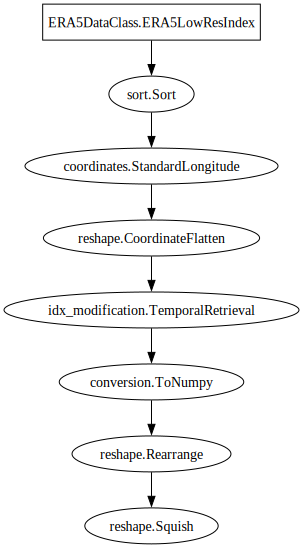

In [4]:
data_preparation = edit.pipeline.Pipeline(
    edit.data.archive.era5lowres(["u", "v", "geopotential", "vorticity"]),
    edit.pipeline.operations.xarray.Sort(
        ["msl", "10u", "10v", "2t", "geopotential", "vorticity"]
    ),
    edit.data.transforms.coordinates.standard_longitude(type="0-360"),
    edit.pipeline.operations.xarray.reshape.CoordinateFlatten("level"),
    # retrieve previous/next samples, dt = 1H
    edit.pipeline.modifications.TemporalRetrieval(
        concat=True, samples=((-1, 1), (1, 1, 1))
    ),
    edit.pipeline.operations.xarray.conversion.ToNumpy(),
    edit.pipeline.operations.numpy.reshape.Rearrange("c t h w -> t c h w"),
    edit.pipeline.operations.numpy.reshape.Squish(axis=0),
)
data_preparation

In [5]:
sample = data_preparation[train_start]
print(len(sample))
print(sample[0].shape)
print(sample[1].shape)

2
(52, 32, 64)
(52, 32, 64)


In [6]:
train_split = edit.pipeline.iterators.DateRange(train_start, train_end, interval="1h")
train_split = train_split.randomise(seed=42)
val_split = edit.pipeline.iterators.DateRange(val_start, val_end, interval="1h")

In [7]:
train_split[:5]

(EDITDatetime('2015-01-01T23'),
 EDITDatetime('2015-01-09T12'),
 EDITDatetime('2015-01-08T04'),
 EDITDatetime('2015-01-05T19'),
 EDITDatetime('2015-01-05T17'))

We use then use precomputed approximate mean and standard deviation using only few random samples, to rescale the input/output data to a reasonable range for model training.

In [8]:
%%time
stats_folder = Path(stats_folder)
stats_folder.mkdir(parents=True, exist_ok=True)

mean_path = stats_folder / "mean.npy"
std_path = stats_folder / "std.npy"

# compute mean/std only if files are missing, to save time
if not mean_path.is_file() or not std_path.is_file():
    samples = np.stack([data_preparation[train_split[i]][0] for i in range(n_samples)])
    mean_approx = np.mean(samples, axis=0)
    std_approx = np.std(samples, axis=0)
    np.save(mean_path, mean_approx)
    np.save(std_path, std_approx)

CPU times: user 54.5 s, sys: 6.21 s, total: 1min
Wall time: 58.9 s


In [ ]:
# Initialise the normaliser with mean and standard deviation paths
normaliser = edit.pipeline.operations.numpy.normalisation.Deviation(
    mean=mean_path, 
    deviation=std_path, 
    expand=False
)

In [ ]:
# Set up the caching mechanism to store processed data in the specified folder with .npy extension
caching_step = edit.pipeline.modifications.Cache(
    cache_folder, 
    pattern_kwargs={'extension': 'npy'}
)

In [ ]:
# Initialise the data preparation pipeline with normalization and caching steps
data_preparation_normed = edit.pipeline.Pipeline(
    data_preparation, 
    normaliser, 
    caching_step
)

In [ ]:
data_preparation_normed

## Model fitting

In [ ]:
class CNN(LightningModule):
    def __init__(
        self,
        *,
        n_features: int,
        layer_sizes: list[int],
        dropout: float,
        learning_rate: float,
    ):
        super().__init__()

        layer_sizes = (n_features,) + tuple(layer_sizes)
        layers = []
        for chan_in, chan_out in zip(layer_sizes[:-1], layer_sizes[1:]):
            layers.extend(
                [
                    nn.Conv2d(chan_in, chan_out, kernel_size=3, stride=1, padding=1),
                    nn.ReLU(),
                    nn.Dropout(p=dropout),
                ]
            )
        layers.append(
            nn.Conv2d(layer_sizes[-1], n_features, kernel_size=3, stride=1, padding=1)
        )
        self.cnn = nn.Sequential(*layers)

        self.learning_rate = learning_rate
        self.loss_function = F.l1_loss

    def forward(self, x):
        return self.cnn(x)

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, targets)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, targets)
        self.log("val_loss", loss)

    def predict_step(self, batch, batch_idx):
        # handle case when data comes from prediction pipeline
        if len(batch) == 2:
            return self(batch[0])
        return self(batch)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return {"optimizer": optimizer}

In [ ]:
# Extract the number of features from the normalised training data
n_features = data_preparation_normed[train_start][0].shape[-3]
print(f"Number of features: {n_features}")

# Define the parameters for the CNN model
model_params = {
    'n_features': n_features,
    'layer_sizes': [64, 64],
    'dropout': 0.6,
    'learning_rate': 1e-5
}

# Initialise the CNN model with the specified parameters
model = CNN(**model_params)

In [ ]:
model

In [ ]:
# ensures that we use CPU if a GPU is available, uncomment to use your GPU
%env CUDA_VISIBLE_DEVICES=

# Data Module
The data module is the component that handles data loading and preprocessing for a machine learning model.<br>

## Integration with PyTorch Lightning

The data module integrates seamlessly with PyTorch Lightning, allowing the one to focus on defining their model and training logic without worrying about the data loading and preprocessing details. When you pass the data module to a PyTorch Lightning trainer, it automatically handles the data loading and batching during training and validation.<br>



**Note:** Here we use `forkserver` to prevent deadlocks on Linux platform when using more than one worker in the data loader.

In [ ]:
# Initialize the data module for training with the specified parameters
data_module = edit.training.data.lightning.PipelineLightningDataModule(
    data_preparation_pipeline,  # Data preparation pipeline
    train_split=train_split,    # Training data split
    valid_split=val_split,      # Validation data split
    batch_size=batch_size,      # Batch size for training
    num_workers=n_workers,      # Number of workers for data loading
    multiprocessing_context="forkserver",  # Multiprocessing context
    persistent_workers=True     # Keep workers alive between epochs
)

In [ ]:
data_module

In [ ]:
chkpt_path = Path(default_root_dir) / "model.ckpt"

In [ ]:
# Initialise the trainer with the specified parameters
trainer = edit.training.lightning.Train(
    model,                  # The CNN model to be trained
    data_module,            # The data module for training
    default_root_dir,       # Directory to save logs and checkpoints
    max_epochs=max_epochs,  # Maximum number of training epochs
    callbacks=[RichProgressBar()]  # Callbacks for training (e.g., progress bar)
)

# Fit the model
trainer.fit(load=False)

# Save the trained model checkpoint
# trainer.save(chkpt_path)

## Predictions

In [ ]:
class ReversedPipeline(edit.pipeline.Pipeline):
    def undo(self, sample):
        return super().apply(sample)
    def apply(self, sample):
        return super().undo(sample)

The code snippet initializes a reverse_pipeline by extracting specific steps from an existing data_preparation_pipeline. The data_preparation_pipeline is a sequence of data preprocessing steps applied to the input data before it is fed into the CNN model. These steps might include normalization, reshaping, and other transformations necessary for preparing the data.<br>

The ReversedPipeline class is designed to reverse the transformations applied by the original pipeline. By passing `data_preparation_pipeline.steps[-5:-1]` to the `ReversedPipeline` constructor, the code extracts the last few steps (from the fifth-to-last to the second-to-last) of the data_preparation_pipeline. These steps are then used to initialise the reverse_pipeline.

In [ ]:
# Extract a pipeline used to convert predictions back to the original space
reverse_pipeline = ReversedPipeline(
    *data_preparation_normed.steps[-5:-1]  # Use the last few steps of the data preparation pipeline
)

In [ ]:
reverse_pipeline

In [ ]:
model_wrapper = edit.training.lightning.Predict(model, data_preparation_normed)
predictor = edit.training.predict.Predictor(model_wrapper, reverse_pipeline)

In [ ]:
test_split = edit.pipeline.iterators.DateRange(test_start, test_end, interval="1h")

y_true = []
y_preds = []

for test_date in track(list(test_split)):
    y = reverse_pipeline.apply(data_preparation_normed[test_date][1])
    y["time"] = y.time.copy(data=[test_date.datetime64()])
    y_true.append(y)

    y_pred = predictor.predict(test_date)
    y_pred["time"] = y_pred.time.copy(data=[test_date.datetime64()])
    y_preds.append(y_pred)

y_true = xr.concat(y_true, dim="time")
y_preds = xr.concat(y_preds, dim="time")

In [ ]:
y_preds

In [ ]:
grid = y_preds.isel(time=slice(3))["z850"].plot(col="time")
grid.fig.suptitle("Predictions", y=1.05)

In [ ]:
grid = y_true.isel(time=slice(3))["z850"].plot(col="time")
grid.fig.suptitle("Ground truth", y=1.05)

## Evaluation

In [ ]:
mae_score = scores.continuous.mae(y_preds, y_true, preserve_dims=["latitude", "longitude"])

In [ ]:
mae_score

In [ ]:
mae_score[["z500", "z850", "z1000"]].to_array(dim="field").plot(col="field")